# Modflow6 and Floypy

### Import Needed Packages
Imported all packages needed to run entire code

In [53]:
import os
import flopy as fp
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

### Set Pathway 
This tells juypter notebook were to save all new created files

In [54]:
modelname = 'esterobay'
modelws = 'esterobay'
path = os.getcwd() #path to working directory
plt.rcParams['figure.figsize'] = (5,5) #defult figure size
plt.rcParams["figure.autolayout"] = True 
path

'C:\\Users\\hanna\\Phython Class'

## Model Parameters

Within the model pararmeters, I first set the size properties for the grid and the quality and size of the layers. Next I fill in the aquifer properties such as porosity and hydraulic conductivity as well as the head, well draw down adn the recharge rate.

In [55]:
#grid properties
Lx = 100 #21120 ft
Ly = 100 #10560 ft
ncol = 100
nrow = 100
delc = Lx/ncol
delr = Ly/nrow

#layers (well heights from Lee County Utilities)
nlay = 1
top = 20 #top of layer in ft
botm = 0 #bottom of layer in ft

#aquifer properties (numbers calculated from data from Uni of Iowa
k_hor = [0.00361] #horizontal hydraulic conductivity, ft/d
k_ver = [0.00361] #vertical hydraulic conductivity, ft/d
porosity = 0.106 #porosity in inches

#Boundary Conditions (hydraulic head found from USGS)
headriver = 3.15 #ft
Qwell= 0.1 #monitor well, no draw down
recharge = 0.126 #ft/d

## Create Simulation
We create the simulation here and are telling the program where it can find the executable file for ModFlow.

In [56]:
# Create Groundwater Simulation
sim = fp.mf6.MFSimulation(sim_name=modelname,
                          version='mf6',
                          exe_name= 'mf6',
                          sim_ws=modelws)

### Time Discretization (Tdis) 
This defines the number of steps and the period length for the simulation.

In [57]:
tdis_rc = [(1.0,1,1.0)] #period length, number of steps, timestamp
tdis=fp.mf6.ModflowTdis(sim,time_units='Days',perioddata=tdis_rc,)

### Iterative Model Solutions (lms)
This sets up the complexity of the iterative methods used for solving a model.

In [58]:
ims = fp.mf6.ModflowIms(sim, complexity='SIMPLE',)

### Groundwater Flow Model (gwf) - We are now labeling the simulation as a groundwater flow model.

In [59]:
gwf = fp.mf6.ModflowGwf(sim, modelname, save_flows=True) 

## Add Packages to gwf

### Discretization Package (gwfdis) 
This package defines the grid, cell properties and boundary conditions

In [60]:
dis = fp.mf6.ModflowGwfdis(gwf,length_units='FEET',nlay=nlay,nrow=nrow,ncol=ncol,delr=delr,delc=delc,top=top,botm=botm,)

### Node Property Flow Package (gwfnpf)
We next need to define the aquifers as confined (0) or unconfined (1).

In [61]:
pf = fp.mf6.ModflowGwfnpf(gwf,save_specific_discharge=True, icelltype=[1],k=k_hor,k33=k_ver,)

### Initial Conditions (Gwfic) 
We are defining the initial river head.

In [62]:
ic = fp.mf6.ModflowGwfic(gwf,strt=headriver)

### Specified Head Package (chd) 
We are telling the simulation where the river is located.

In [81]:
chd_spd = []
for r in range(nrow):
    chd_spd.append([(0,r,ncol -50),headriver]) #[(layer,row,
chd = fp.mf6.ModflowGwfchd(gwf,stress_period_data=chd_spd,)

### Recharge Package (gwfrcha) 
We are now inputing the recharge rate. 

In [64]:
rch = fp.mf6.ModflowGwfrcha(gwf,recharge=recharge,pname='rch')

### Well Package (gwfwel)
In this step I am telling the simulation where the wells are located on the grid. 

In [65]:
well_row_col = [[45,25],[28,58],[80,35],[78,60]] #row and column of well
wel_spd = []
for rc in well_row_col:
    r = rc[0]
    c = rc[1]
    wel_spd.append([(0,r,c),Qwell])

wel = fp.mf6.ModflowGwfwel(gwf,stress_period_data=wel_spd,)

### Output Control (gwfoc) 
This is limiting the output to the river based on the parameters that were set above.

In [66]:
oc = fp.mf6.ModflowGwfoc(gwf,budget_filerecord=f"{modelname}.cbc",head_filerecord=f"{modelname}.hds", saverecord=[("HEAD","ALL"),("BUDGET","ALL")])

## Check Input

### Solve Models (Top View and Cross Section View) 
In this step we are ploting the aerial view of the grid, showing the 4 wells and the river, we are also creating the cross sectional views of the wells compared to the river. 

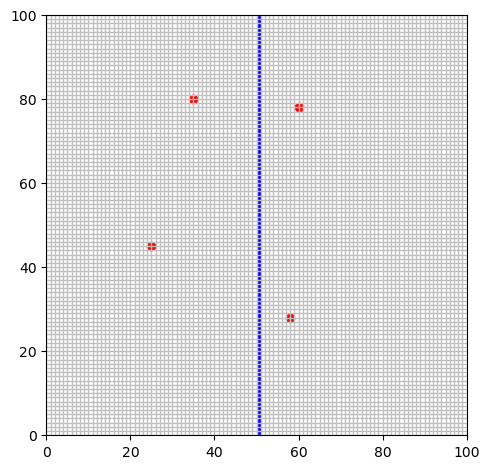

In [67]:
pmv = fp.plot.PlotMapView(model=gwf)
pmv.plot_bc('CHD', color='b')
for rc in well_row_col:
    plt.plot(rc[1], rc[0], 'ro') 
pmv.plot_grid(colors='silver',lw=1)

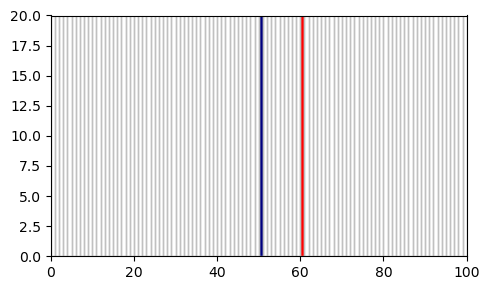

In [68]:
#Cross Section View
plt.figure(figsize=(5,3))
pxs = fp.plot.PlotCrossSection(model=gwf,line={"Row": 78})
pxs.plot_bc('CHD')
pxs.plot_bc('WEL')
pxs.plot_grid(colors='silver',lw=1);

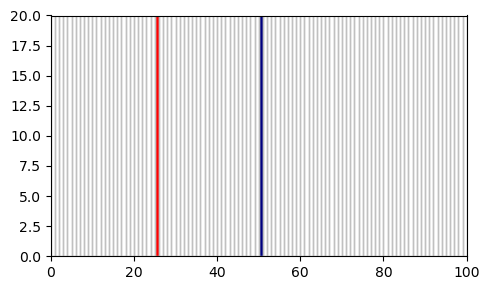

In [69]:
#Cross Section View
plt.figure(figsize=(5,3))
pxs = fp.plot.PlotCrossSection(model=gwf,line={"Row": 45})
pxs.plot_bc('CHD')
pxs.plot_bc('WEL')
pxs.plot_grid(colors='silver',lw=1);

### Run Simulation 
Once all of the parameters are correctly defined we run the simulation.

In [70]:
#Run Simulation
#mf6_exe_path = 'mf6.exe'
sim.write_simulation()
sim.run_simulation();

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing model esterobay...
    writing model name file...
    writing package dis...
    writing package npf...
    writing package ic...
    writing package chd_0...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 100 based on size of stress_period_data
    writing package rch...
    writing package wel_0...
INFORMATION: maxbound in ('gwf6', 'wel', 'dimensions') changed to 4 based on size of stress_period_data
    writing package oc...
FloPy is using the following executable to run the model: ..\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.4.4 02/13/2024

   MODFLOW 6 compiled Feb 13 2024 15:40:13 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
                      

## Read and Visualize Results

Read Heads - We are reading the minimum and maximum head from the finished simulation.

In [74]:
fname=os.path.join(modelws, f'{modelname}.hds')
hdobj = fp.utils.HeadFile(fname)
head = hdobj.get_data(mflay=0)
print('minimum head in model: ', head.min())
print('maximum head in model: ', head.max())

minimum head in model:  3.15
maximum head in model:  2462.317218368039


### Contour Plot 
We are ploting the simulation in a contour plot.

AttributeError: module 'matplotlib.pyplot' has no attribute 'clabels'

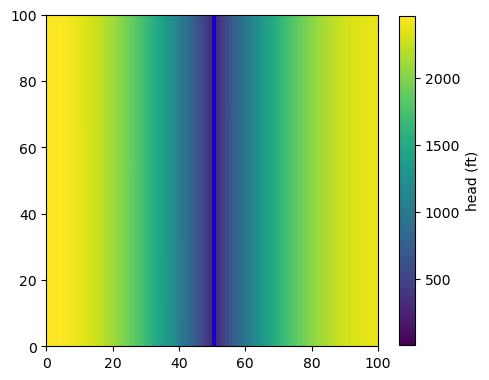

In [75]:
#Contour Plot
pmv=fp.plot.PlotMapView(model=gwf)
qm=pmv.plot_array(head)
plt.colorbar(qm,shrink=0.7,label='head (ft)')
cs = pmv.contour_array(head,levels=range(0,25),linewidths=1,colors='b')
plt.clabels(cs, fmt='%1.0f')
plt.title('heads in layer 1')

### Save Image

In [76]:
plt.savefig('contour.png')

<Figure size 500x500 with 0 Axes>

## Water Balance 
We are taking the values from the simulation to calculate the Input and Output.

In [93]:
fname=os.path.join(modelws, f"{modelname}.cbc")
cbb = fp.utils.CellBudgetFile(fname)

Qwell=cbb.get_data(text='WEL')[0]
Qrch=cbb.get_data(text='RCH')[0]
Qchd=cbb.get_data(text='CHD')[0]
Vin=Qrch['q'].sum()
Vout=Qwell['q'].sum()+Qchd['q'].sum()
print(f'In:{Vin:.1f} m^3/d')
print(f'Out:{Vout:.1f} m^3/d')

In:1247.4 m^3/d
Out:-1247.4 m^3/d
